In [13]:
import pandas as pd
import json
import os
import backtrader as bt
import backtrader.analyzers as btanalyzers
import numpy as np
from collections import defaultdict
from tqdm import tqdm

from datetime import datetime, timedelta
import os.path
import sys

from strategies import WilliamsRStrategy, CCIStrategy
from analyzers import InMarketAnalyzer, CashValueAnalyzer, SortinoRatio

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

## Split Data into Train and Test

In [4]:
forex_files = [("Data/forex_usdaud_1h.csv", "Data/forex_usdaud_1h_2.csv"), 
               ("Data/forex_usdchf_1h.csv", "Data/forex_usdchf_1h_2.csv"),
               ("Data/forex_usdgbp_1h.csv", "Data/forex_usdgbp_1h_2.csv"),
               ("Data/forex_usdnzd_1h.csv", "Data/forex_usdnzd_1h_2.csv"),
               ("Data/forex_usdcad_1h.csv", "Data/forex_usdcad_1h_2.csv"),
               ("Data/forex_usdmxn_1h.csv", "Data/forex_usdmxn_1h_2.csv"),
               ("Data/forex_usdeur_1h.csv", "Data/forex_usdeur_1h_2.csv"),
               ("Data/forex_usdjpy_1h.csv", "Data/forex_usdjpy_1h_2.csv"),
               ("Data/forex_usdsek_1h.csv", "Data/forex_usdsek_1h_2.csv"),
               ("Data/forex_usdhkd_1h.csv", "Data/forex_usdhkd_1h_2.csv")]

for pair in forex_files:
  df1 = pd.read_csv(pair[0])
  df2 = pd.read_csv(pair[1])

  # Ensure the date column is in datetime format
  df1['Datetime'] = pd.to_datetime(df1['Datetime'], utc=True).dt.tz_convert(None)
  df2['Datetime'] = pd.to_datetime(df2['Datetime'], utc=True).dt.tz_convert(None)

  # Concatenate the dataframes and drop duplicates based on the 'date' column
  merged_df = pd.concat([df1, df2]).drop_duplicates(subset='Datetime')
  merged_df['Datetime'] = pd.to_datetime(merged_df['Datetime'])
  merged_df = merged_df.sort_values(by='Datetime')

  # Save the merged data to a new CSV file
  title = pair[0].split("/")[1].split("_")[1]
  merged_df.to_csv(f'Data/{title}.csv', index=False)

In [15]:
train_test_cutoff = datetime.now() - timedelta(days=182)

forex_files = ["forex_data/usdaud.csv", "forex_data/usdcad.csv",
               "forex_data/usdchf.csv", "forex_data/usdeur.csv",
               "forex_data/usdgbp.csv", "forex_data/usdhkd.csv",
               "forex_data/usdjpy.csv", "forex_data/usdmxn.csv",
               "forex_data/usdnzd.csv", "forex_data/usdsek.csv",]
forex_symbols = {}

os.makedirs("Data/train", exist_ok=True)
os.makedirs("Data/test", exist_ok=True)

for file in forex_files:
  df = pd.read_csv(file)

  # Convert the date column to datetime format if not already in datetime
  df['Datetime'] = pd.to_datetime(df['Datetime'], utc=True).dt.tz_convert(None)

  # Split the data into train and test sets
  train_data = df[df['Datetime'] < train_test_cutoff]
  test_data = df[df['Datetime'] >= train_test_cutoff]

  train_data = train_data.sort_values(by='Datetime', ascending=True)
  test_data = test_data.sort_values(by='Datetime', ascending=True)

  # Extract the symbol name from the file name
  symbol = file.split('/')[1].split('.')[0]
  forex_symbols[symbol] = (train_data, test_data)

  # Save the train and test datasets into their respective folders
  train_file_path = f"Data/train/{symbol}_train.csv"
  test_file_path = f"Data/test/{symbol}_test.csv"

  train_data.to_csv(train_file_path, index=False)
  test_data.to_csv(test_file_path, index=False)

In [5]:
# Train data will be ~75% of the data and test data will be ~25% of the data
train_test_cutoff = datetime.now() - timedelta(days=182)

forex_files = ["Data/forex_usdaud_1h.csv", "Data/forex_usdchf_1h.csv", 
               "Data/forex_usdgbp_1h.csv", "Data/forex_usdnzd_1h.csv",
               "Data/forex_usdcad_1h.csv", "Data/forex_usdmxn_1h.csv",
               "Data/forex_usdeur_1h.csv", "Data/forex_usdjpy_1h.csv",
               "Data/forex_usdsek_1h.csv", "Data/forex_usdhkd_1h.csv",]
forex_symbols = {}

os.makedirs("Data/train", exist_ok=True)
os.makedirs("Data/test", exist_ok=True)

for file in forex_files:
  df = pd.read_csv(file)

  # Convert the date column to datetime format if not already in datetime
  df['Datetime'] = pd.to_datetime(df['Datetime'], utc=True).dt.tz_convert(None)

  # Split the data into train and test sets
  train_data = df[df['Datetime'] < train_test_cutoff]
  test_data = df[df['Datetime'] >= train_test_cutoff]

  train_data = train_data.sort_values(by='Datetime', ascending=True)
  test_data = test_data.sort_values(by='Datetime', ascending=True)

  # Extract the symbol name from the file name
  symbol = file.split('_')[1]
  forex_symbols[symbol] = (train_data, test_data)

  # Save the train and test datasets into their respective folders
  train_file_path = f"Data/train/{symbol}_train.csv"
  test_file_path = f"Data/test/{symbol}_test.csv"

  train_data.to_csv(train_file_path, index=False)
  test_data.to_csv(test_file_path, index=False)


## Resample Data if Needed

In [53]:
def resample_to_hourly(data: pd.DataFrame):
    hourly_data = data['Price'].resample('H').ohlc()

    return hourly_data

## Use Train Data to Optimize Parameters

In [6]:
train_data = {}
train_dir = "Data/train"

for file in os.listdir(train_dir):
  symbol = file.split('_')[0]
  df = pd.read_csv(f"{train_dir}/{file}")
  df['Datetime'] = pd.to_datetime(df['Datetime'], utc=True).dt.tz_convert(None)
  train_data[symbol] = df

In [7]:
def print_results(results):
  #, data, start_cash=100000, start_date=datetime(1993, 1, 29), end_date=datetime(2024, 6, 14)
  trade_stats = results.analyzers.trade_stats.get_analysis()
  drawdown_stats = results.analyzers.drawdown.get_analysis()
  in_market_stats = results.analyzers.in_market.get_analysis()

  # Print trade statistics
  print("Trade Stats:")
  print(f"Total trades: {trade_stats.total.closed}")
  print(f"Winning trades: {trade_stats.won.total}")
  print(f"Losing trades: {trade_stats.lost.total}")
  print(f"Time in market: {in_market_stats["Total In-Market Bars"] / in_market_stats["Total Bars"] * 100:.2f}%")
  print(f"Average percent gain: {in_market_stats["Total Percent Gain"] / trade_stats.total.closed:.2f}%")
  print(f"Profit factor: {in_market_stats["Total Gains"] / in_market_stats["Total Losses"]:.1f}")

  # Print drawdown statistics
  print("\nDrawdown Stats:")
  print(f"Max Drawdown: {drawdown_stats.max.drawdown:.2f}%")
  print(f"Max Drawdown Duration: {drawdown_stats.max.len} bars")

  returns = results.analyzers.returns.get_analysis()

  print("\nStrategy Return Stats:")
  print(f"Total Return: {returns['rtot'] * 100:.2f}%")
  print(f"Annualized Return: {returns['rnorm'] * 100:.2f}%")
  print(f"Risk adjusted return: {(returns['rnorm']) / (in_market_stats["Total In-Market Bars"] / in_market_stats["Total Bars"])*100:.2f}%")

In [8]:
def opt_universe(symbol, data_path, periods = [2],
                          upperbands = [-30],
                          lowerbands = [-90]):
  cerebro = bt.Cerebro(cheat_on_open=True)
  start_date = train_data[symbol]['Datetime'].min()
  end_date = train_data[symbol]['Datetime'].max()
  data = bt.feeds.YahooFinanceCSVData(dataname=data_path, fromdate=start_date, todate=end_date, adjclose=True, round=False)
  cerebro.adddata(data)

  # Add the WilliamsR strategy
  cerebro.optstrategy(CCIStrategy, period=periods, upperband=upperbands, lowerband=lowerbands)
  cerebro.broker.setcommission(commission=0.0)

  # Set initial capital and broker settings
  # This code was assited using Codeium autocomplete
  start_cash = 100000.0000
  cerebro.broker.setcash(start_cash)
  cerebro.addsizer(bt.sizers.PercentSizer, percents=100)
  cerebro.addanalyzer(btanalyzers.TradeAnalyzer, _name="trade_stats")
  cerebro.addanalyzer(btanalyzers.DrawDown, _name="drawdown")
  cerebro.addanalyzer(btanalyzers.Returns, _name="returns")
  cerebro.addanalyzer(btanalyzers.SharpeRatio, _name="sharpe")
  cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='timereturn')
  cerebro.addanalyzer(InMarketAnalyzer, _name="in_market")
  cerebro.addanalyzer(CashValueAnalyzer, _name="cash_value")
  cerebro.addanalyzer(SortinoRatio, _name='sortino')

  # Print starting capital
  # print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

  # Run the strategy
  runs = cerebro.run()

  # Print final capital
  # print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
  return runs

def backtest(data_path, period = 2,
                          upperband = -30,
                          lowerband = -90,):
  cerebro = bt.Cerebro(cheat_on_open=True)
  data = bt.feeds.YahooFinanceCSVData(dataname=data_path, adjclose=True, round=False)
  cerebro.adddata(data)

  # Add the WilliamsR strategy
  cerebro.addstrategy(WilliamsRStrategy, period=period, upperband=upperband, lowerband=lowerband)
  cerebro.broker.setcommission(commission=0.0)

  # Set initial capital and broker settings
  # This code was assited using Codeium autocomplete
  start_cash = 100000.0000
  cerebro.broker.setcash(start_cash)
  cerebro.addsizer(bt.sizers.PercentSizer, percents=100)
  cerebro.addanalyzer(btanalyzers.TradeAnalyzer, _name="trade_stats")
  cerebro.addanalyzer(btanalyzers.DrawDown, _name="drawdown")
  cerebro.addanalyzer(btanalyzers.Returns, _name="returns")
  cerebro.addanalyzer(bt.analyzers.SharpeRatio, 
                    _name='sharpe',
                    timeframe=bt.TimeFrame.Minutes,  # Timeframe to match hourly data
                    compression=60,                  # Compression for hourly data (60 minutes)
                    riskfreerate=0.0)
  cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='timereturn')
  cerebro.addanalyzer(InMarketAnalyzer, _name="in_market")
  cerebro.addanalyzer(CashValueAnalyzer, _name="cash_value")
  cerebro.addanalyzer(SortinoRatio, _name='sortino')
  
  results = cerebro.run()

  return results

In [11]:
results = {}
opt_periods = list(range(10,15))
opt_upperbands = list(range(95,100,5))
opt_lowerbands = list(range(-95,-100,-5))
for symbol in tqdm(train_data.keys()):
  runs = opt_universe(symbol, f"Data/train/{symbol}_train.csv",periods=opt_periods,upperbands=opt_upperbands,lowerbands=opt_lowerbands)
  results[symbol] = runs

 70%|███████   | 7/10 [00:45<00:19,  6.45s/it]


KeyboardInterrupt: 

In [8]:
for symbol in train_data.keys():
  print("-----------------")
  print(f"{symbol} Results:")
  print_results(results[symbol][0][0])
  print("-----------------")

-----------------
usdcad Results:
Trade Stats:
Total trades: 760
Winning trades: 507
Losing trades: 253
Time in market: 44.49%
Average percent gain: 0.01%
Profit factor: 1.2

Drawdown Stats:
Max Drawdown: 4.27%
Max Drawdown Duration: 2230 bars

Strategy Return Stats:
Total Return: 8.29%
Annualized Return: 5.03%
Risk adjusted return: 11.29%
-----------------
-----------------
usdchf Results:
Trade Stats:
Total trades: 829
Winning trades: 550
Losing trades: 279
Time in market: 49.57%
Average percent gain: 0.01%
Profit factor: 1.2

Drawdown Stats:
Max Drawdown: 6.87%
Max Drawdown Duration: 4769 bars

Strategy Return Stats:
Total Return: 10.22%
Annualized Return: 6.23%
Risk adjusted return: 12.57%
-----------------
-----------------
usdgbp Results:
Trade Stats:
Total trades: 914
Winning trades: 602
Losing trades: 312
Time in market: 48.88%
Average percent gain: 0.01%
Profit factor: 1.1

Drawdown Stats:
Max Drawdown: 5.30%
Max Drawdown Duration: 3638 bars

Strategy Return Stats:
Total Retur

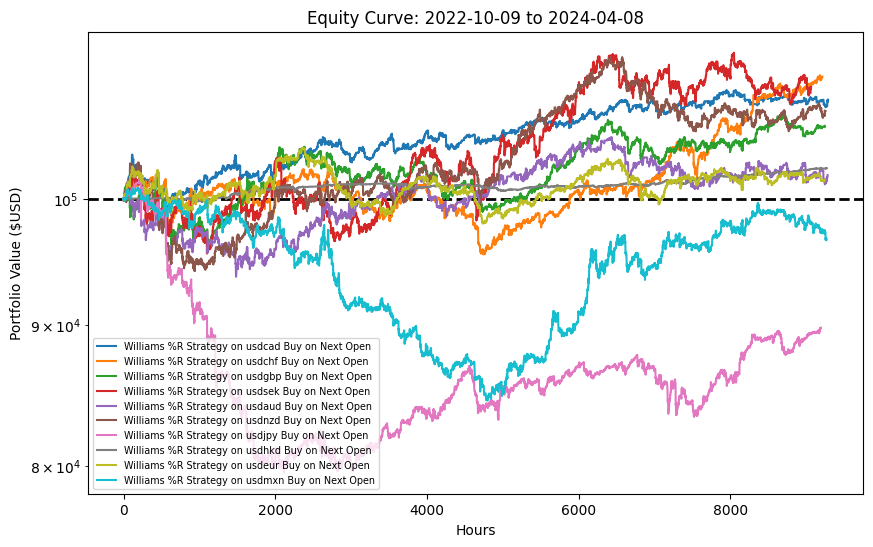

In [9]:
# Some of this code was assisted by Codeium autocomplete
plt.figure(figsize=(10, 6))
plt.axhline(y=100000, color='black', linestyle='--', linewidth=2)

for symbol in train_data.keys():
  for strategy in results[symbol][:1]:
    equity_curve = strategy[0].analyzers.cash_value.get_analysis()
    plt.plot(equity_curve, label=f'Williams %R Strategy on {symbol} Buy on Next Open')

# Set the y-ticks and labels
plt.title('Equity Curve: 2022-10-09 to 2024-04-08')
plt.xlabel('Hours')
plt.ylabel('Portfolio Value ($USD)')

plt.yscale('log')
plt.legend(fontsize='x-small')
plt.show()

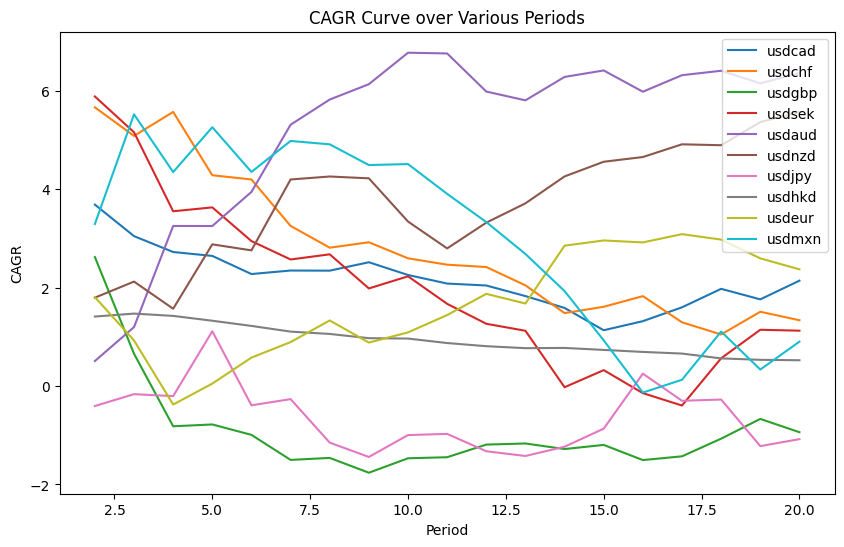

In [10]:
plt.figure(figsize=(10, 6))
for strat_name in results:
  runs = results[strat_name]
  avg_profits = []
  for period in opt_periods:
    profit = [strat[0].analyzers.returns.get_analysis()['rnorm']*100 for strat in runs if strat[0].params.period == period]
    avg_profits.append(sum(profit)/len(profit))
  plt.plot(opt_periods, avg_profits, label=strat_name)
plt.title('CAGR Curve over Various Periods')
plt.xlabel('Period')
plt.ylabel('CAGR')
plt.legend()
plt.show()

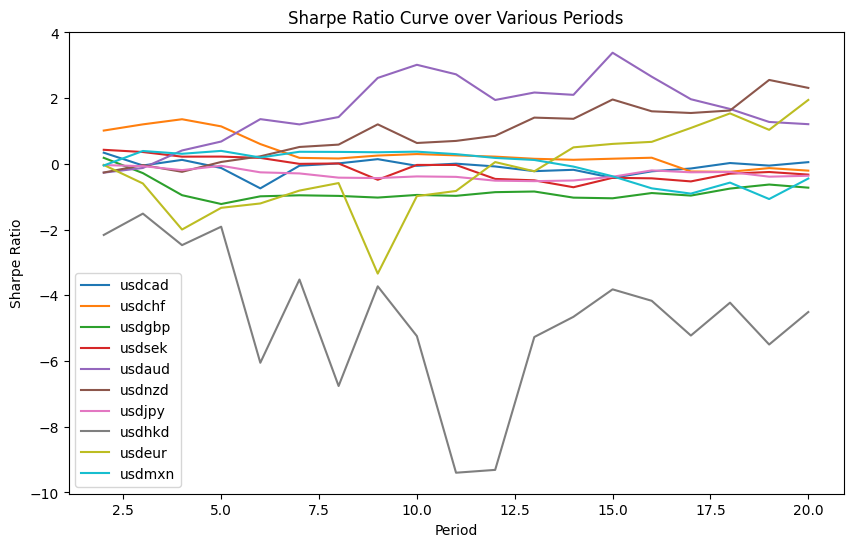

In [11]:
plt.figure(figsize=(10, 6))
for strat_name in results:
  runs = results[strat_name]
  avg_profits = []
  for period in opt_periods:
    profit = [strat[0].analyzers.sharpe.get_analysis()['sharperatio'] for strat in runs if strat[0].params.period == period]
    avg_profits.append(sum(profit)/len(profit))
  plt.plot(opt_periods, avg_profits, label=strat_name)
plt.title('Sharpe Ratio Curve over Various Periods')
plt.xlabel('Period')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.show()

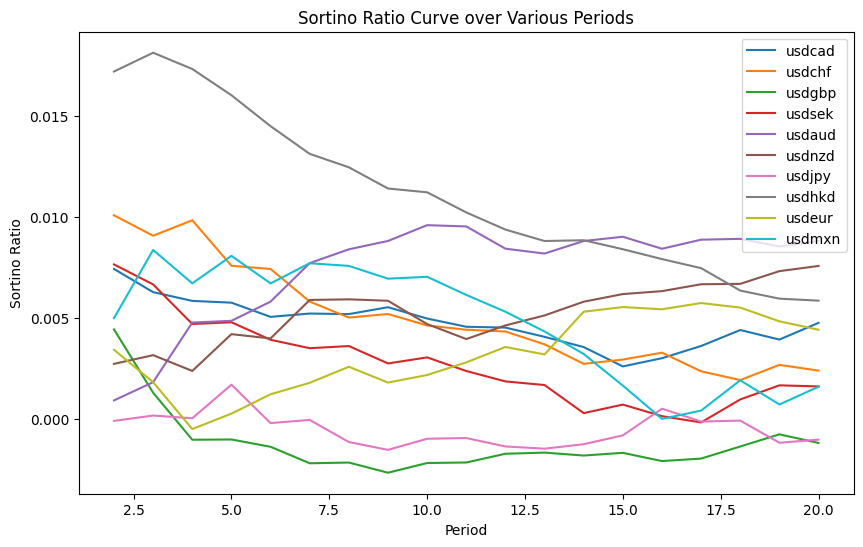

In [12]:
plt.figure(figsize=(10, 6))
for strat_name in results:
  runs = results[strat_name]
  avg_profits = []
  for period in opt_periods:
    profit = [strat[0].analyzers.sortino.get_analysis()['Sortino Ratio'] for strat in runs if strat[0].params.period == period]
    avg_profits.append(sum(profit)/len(profit))
  plt.plot(opt_periods, avg_profits, label=strat_name)
plt.title('Sortino Ratio Curve over Various Periods')
plt.xlabel('Period')
plt.ylabel('Sortino Ratio')
plt.legend()
plt.show()

In [13]:
data_results = defaultdict(list)
for strat_name in results:
  runs = results[strat_name]
  for strat in runs:
    returns_stats = strat[0].analyzers.returns.get_analysis()
    trade_stats = strat[0].analyzers.trade_stats.get_analysis()
    drawdown_stats = strat[0].analyzers.drawdown.get_analysis()
    in_market_stats = strat[0].analyzers.in_market.get_analysis()

    data_results["symbol"].append(strat_name)
    data_results["period"].append(strat[0].params.period)
    data_results["lowerband"].append(strat[0].params.lowerband)
    data_results["upperband"].append(strat[0].params.upperband)
    data_results["total_return"].append(returns_stats['rtot'])
    data_results["cagr"].append(returns_stats['rnorm'])
    data_results["return_per_exposer"].append(returns_stats['rnorm'] / (in_market_stats["Total In-Market Bars"] / in_market_stats["Total Bars"]))
    data_results["sharpe"].append(strat[0].analyzers.sharpe.get_analysis()['sharperatio'])
    data_results["sortino"].append(strat[0].analyzers.sortino.get_analysis()['Sortino Ratio'])
    data_results["total_trades"].append(trade_stats.total.closed)
    data_results["winning_trades"].append(trade_stats.won.total)
    data_results["losing_trades"].append(trade_stats.lost.total)
    data_results["time_in_market"].append(in_market_stats["Total In-Market Bars"] / in_market_stats["Total Bars"])
    data_results["profit_factor"].append(in_market_stats["Total Gains"] / in_market_stats["Total Losses"])
    data_results["avg_gain"].append(in_market_stats["Total Percent Gain"] / trade_stats.total.closed)
    data_results["max_drawdown"].append(drawdown_stats.max.drawdown)
    data_results["max_drawdown_duration"].append(drawdown_stats.max.len)
    
pd.DataFrame(data_results).to_csv("Data/forex_opt_results.csv", index=False)

## Find Best Parameters for Each Currency Pair

In [14]:
metrics_df = pd.read_csv("Data/forex_opt_results.csv")
# For each symbol value, get the best period, lowerband, and upperband values for the highest CAGR
best_cagr = metrics_df.loc[metrics_df.groupby('symbol')['cagr'].idxmax()]
# For each symbol value, get the best period, lowerband, and upperband values for the highest Sharpe
best_sharpe = metrics_df.loc[metrics_df.groupby('symbol')['sharpe'].idxmax()]
# For each symbol value, get the best period, lowerband, and upperband values for the highest Sortino
best_sortino = metrics_df.loc[metrics_df.groupby('symbol')['sortino'].idxmax()]

metrics_df

,symbol,period,lowerband,upperband,total_return,cagr,return_per_exposer,sharpe,sortino,total_trades,winning_trades,losing_trades,time_in_market,profit_factor,avg_gain,max_drawdown,max_drawdown_duration
0,usdcad,2,-60,-5,0.082891,0.050256,0.112949,0.931303,0.010651,760,507,253,0.444947,1.178587,0.011341,4.266088,2230
1,usdcad,2,-65,-5,0.078998,0.047840,0.118593,0.598014,0.009934,689,469,220,0.403401,1.184009,0.011897,4.331895,2464
2,usdcad,2,-70,-5,0.066456,0.040095,0.111600,0.474760,0.008350,599,403,196,0.359272,1.173102,0.011433,4.695233,2591
3,usdcad,2,-75,-5,0.052950,0.031818,0.109531,0.542342,0.006445,487,321,166,0.290496,1.163210,0.011120,4.459497,3122
4,usdcad,2,-80,-5,0.068535,0.041375,0.206452,0.885213,0.007820,353,239,114,0.200409,1.307183,0.020031,2.167945,3164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9305,usdmxn,20,-70,-35,0.036100,0.021584,0.053657,0.155226,0.003672,572,365,207,0.402265,1.070283,0.006757,5.844378,4789
9306,usdmxn,20,-75,-35,0.007052,0.004180,0.011585,-0.666460,0.000894,502,318,184,0.360841,1.018680,0.001775,7.311309,4978
9307,usdmxn,20,-80,-35,0.020416,0.012151,0.038907,-0.194699,0.002077,428,278,150,0.312298,1.047017,0.004601,5.826150,5481
9308,usdmxn,20,-85,-35,0.020614,0.012269,0.047628,-0.245732,0.002014,356,225,131,0.257605,1.056884,0.005589,4.636557,5080


In [32]:
def find_best_params(metrics_df, target, n=1):

    # Create a dictionary to store the best triple for each symbol
    best_triples = {}

    # Iterate through each symbol in the DataFrame
    for symbol in metrics_df['symbol'].unique():
        # Filter the DataFrame to only include rows for the current symbol
        symbol_data = metrics_df[metrics_df['symbol'] == symbol]

        best_avg_target = float('-inf')
        best_triple = None

        # Iterate through each row for the current symbol
        for index, row in symbol_data.iterrows():
            # Get the neighboring points for the current row, considering n neighbors
            neighbors = symbol_data[
                (symbol_data['period'].between(row['period'] - n, row['period'] + n)) &
                (symbol_data['lowerband'].between(row['lowerband'] - 5 * n, row['lowerband'] + 5 * n)) &
                (symbol_data['upperband'].between(row['upperband'] - 5 * n, row['upperband'] + 5 * n))
            ]

            # Calculate the average CAGR of the current point and its neighbors
            avg_target = neighbors[target].mean()

            # Update the best triple if the current average CAGR is higher
            if avg_target > best_avg_target:
                best_avg_target = avg_target
                best_triple = (row['period'], row['lowerband'], row['upperband'])

        # Store the best triple for the current symbol
        best_triples[symbol] = best_triple

    return best_triples

In [45]:
best_params = {}
for n in [0,1,3,5]:
  best_params[n] = find_best_params(metrics_df, "sortino", n=n)


In [46]:
test_results = {}

for symbol in metrics_df['symbol'].unique():
    test_results[symbol] = {}
    for n in [0, 1, 3, 5]:
      test_results[symbol][n] = backtest(f"Data/test/{symbol}_test.csv", period = best_params[n][symbol][0], lowerband=best_params[n][symbol][1], upperband=best_params[n][symbol][2])

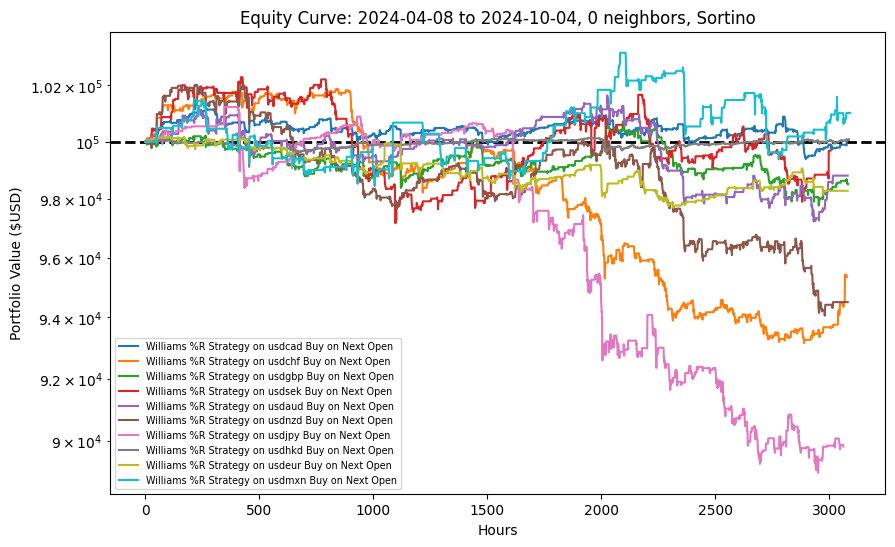

In [47]:
# Some of this code was assisted by Codeium autocomplete
plt.figure(figsize=(10, 6))
plt.axhline(y=100000, color='black', linestyle='--', linewidth=2)

for symbol in metrics_df['symbol'].unique():
  for strategy in test_results[symbol][0]:
    equity_curve = strategy.analyzers.cash_value.get_analysis()
    plt.plot(equity_curve, label=f'Williams %R Strategy on {symbol} Buy on Next Open')

# Set the y-ticks and labels
plt.title('Equity Curve: 2024-04-08 to 2024-10-04, 0 neighbors, Sortino')
plt.xlabel('Hours')
plt.ylabel('Portfolio Value ($USD)')

plt.yscale('log')
plt.legend(fontsize='x-small')
plt.show()

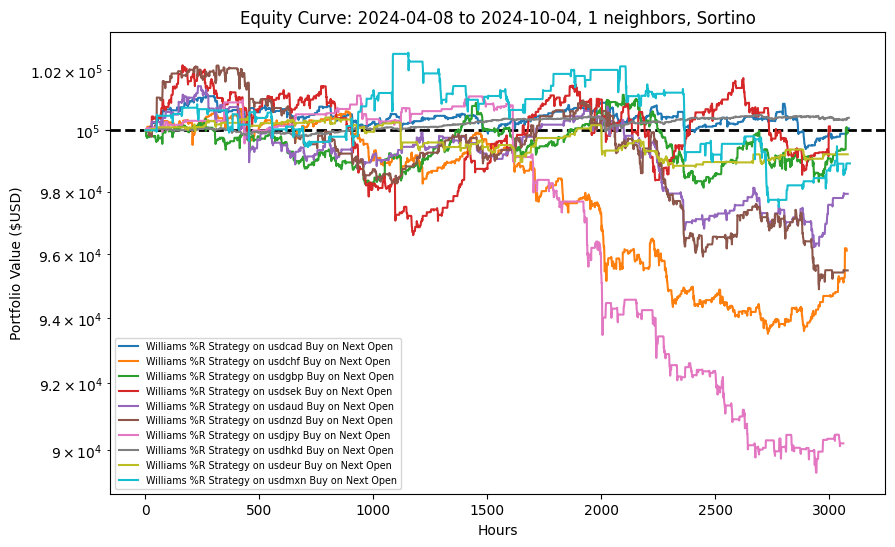

In [48]:
# Some of this code was assisted by Codeium autocomplete
plt.figure(figsize=(10, 6))
plt.axhline(y=100000, color='black', linestyle='--', linewidth=2)

for symbol in metrics_df['symbol'].unique():
  for strategy in test_results[symbol][1]:
    equity_curve = strategy.analyzers.cash_value.get_analysis()
    plt.plot(equity_curve, label=f'Williams %R Strategy on {symbol} Buy on Next Open')

# Set the y-ticks and labels
plt.title('Equity Curve: 2024-04-08 to 2024-10-04, 1 neighbors, Sortino')
plt.xlabel('Hours')
plt.ylabel('Portfolio Value ($USD)')

plt.yscale('log')
plt.legend(fontsize='x-small')
plt.show()

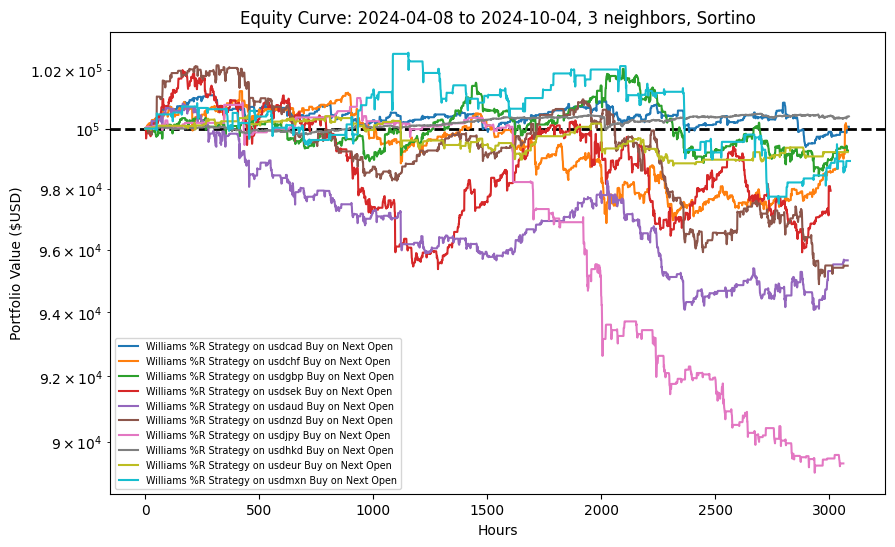

In [49]:
# Some of this code was assisted by Codeium autocomplete
plt.figure(figsize=(10, 6))
plt.axhline(y=100000, color='black', linestyle='--', linewidth=2)

for symbol in metrics_df['symbol'].unique():
  for strategy in test_results[symbol][3]:
    equity_curve = strategy.analyzers.cash_value.get_analysis()
    plt.plot(equity_curve, label=f'Williams %R Strategy on {symbol} Buy on Next Open')

# Set the y-ticks and labels
plt.title('Equity Curve: 2024-04-08 to 2024-10-04, 3 neighbors, Sortino')
plt.xlabel('Hours')
plt.ylabel('Portfolio Value ($USD)')

plt.yscale('log')
plt.legend(fontsize='x-small')
plt.show()

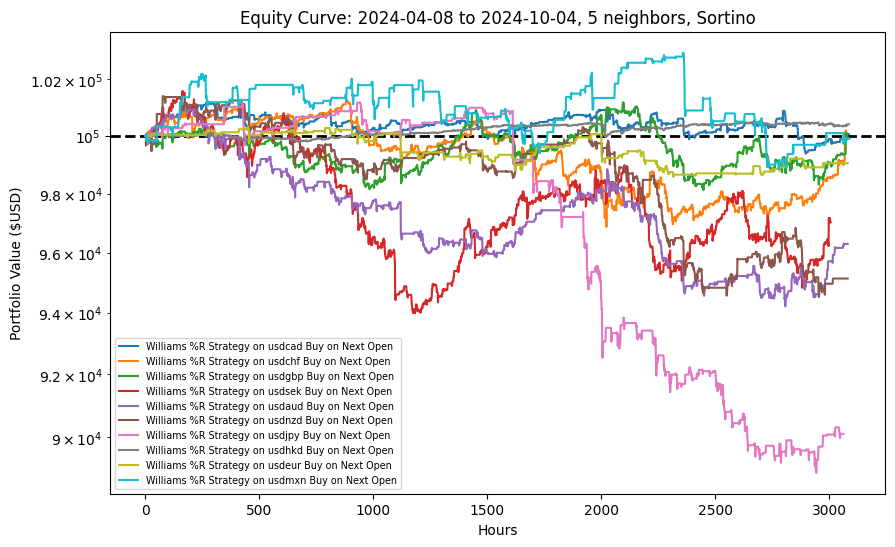

In [50]:
# Some of this code was assisted by Codeium autocomplete
plt.figure(figsize=(10, 6))
plt.axhline(y=100000, color='black', linestyle='--', linewidth=2)

for symbol in metrics_df['symbol'].unique():
  for strategy in test_results[symbol][5]:
    equity_curve = strategy.analyzers.cash_value.get_analysis()
    plt.plot(equity_curve, label=f'Williams %R Strategy on {symbol} Buy on Next Open')

# Set the y-ticks and labels
plt.title('Equity Curve: 2024-04-08 to 2024-10-04, 5 neighbors, Sortino')
plt.xlabel('Hours')
plt.ylabel('Portfolio Value ($USD)')

plt.yscale('log')
plt.legend(fontsize='x-small')
plt.show()

In [51]:
final_results = defaultdict(list)
for strat_name in test_results:
  for n in test_results[strat_name]:
    strat = test_results[strat_name][n]
    returns_stats = strat[0].analyzers.returns.get_analysis()
    trade_stats = strat[0].analyzers.trade_stats.get_analysis()
    drawdown_stats = strat[0].analyzers.drawdown.get_analysis()
    in_market_stats = strat[0].analyzers.in_market.get_analysis()

    final_results["symbol"].append(strat_name)
    final_results["period"].append(strat[0].params.period)
    final_results["lowerband"].append(strat[0].params.lowerband)
    final_results["upperband"].append(strat[0].params.upperband)
    final_results["neighbors"].append(n)
    final_results["total_return"].append(returns_stats['rtot'])
    final_results["cagr"].append(returns_stats['rnorm'])
    final_results["return_per_exposer"].append(returns_stats['rnorm'] / (in_market_stats["Total In-Market Bars"] / in_market_stats["Total Bars"]))
    final_results["sharpe"].append(strat[0].analyzers.sharpe.get_analysis()['sharperatio'])
    final_results["sortino"].append(strat[0].analyzers.sortino.get_analysis()['Sortino Ratio'])
    final_results["total_trades"].append(trade_stats.total.closed)
    final_results["winning_trades"].append(trade_stats.won.total)
    final_results["losing_trades"].append(trade_stats.lost.total)
    final_results["time_in_market"].append(in_market_stats["Total In-Market Bars"] / in_market_stats["Total Bars"])
    final_results["profit_factor"].append(in_market_stats["Total Gains"] / in_market_stats["Total Losses"])
    final_results["avg_gain"].append(in_market_stats["Total Percent Gain"] / trade_stats.total.closed)
    final_results["max_drawdown"].append(drawdown_stats.max.drawdown)
    final_results["max_drawdown_duration"].append(drawdown_stats.max.len)
      
pd.DataFrame(final_results).to_csv("Data/forex_test_results_sortino.csv", index=False)

In [52]:
pd.read_csv("Data/forex_test_results.csv")

,symbol,period,lowerband,upperband,neighbors,total_return,cagr,return_per_exposer,sharpe,sortino,total_trades,winning_trades,losing_trades,time_in_market,profit_factor,avg_gain,max_drawdown,max_drawdown_duration
0,usdcad,2,-60,-35,0,0.000623,0.001014,0.003992,0.003505,0.000451,259,169,90,0.253886,1.006596,0.000241,1.774887,2819
1,usdcad,2,-60,-35,1,0.000623,0.001014,0.003992,0.003505,0.000451,259,169,90,0.253886,1.006596,0.000241,1.774887,2819
2,usdcad,2,-60,-35,3,0.000623,0.001014,0.003992,0.003505,0.000451,259,169,90,0.253886,1.006596,0.000241,1.774887,2819
3,usdcad,2,-60,-35,5,0.000623,0.001014,0.003992,0.003505,0.000451,259,169,90,0.253886,1.006596,0.000241,1.774887,2819
4,usdchf,2,-60,-25,0,-0.008721,-0.014079,-0.032253,-0.018841,-0.003005,318,208,110,0.436505,0.961594,-0.002404,5.231416,2664
5,usdchf,3,-60,-35,1,-0.039634,-0.062406,-0.162423,-0.088072,-0.014076,284,178,106,0.384216,0.807399,-0.013419,7.135549,2654
6,usdchf,2,-60,-35,3,0.000115,0.000186,0.000490,0.001599,0.000268,346,225,121,0.380318,1.006142,0.000336,4.347573,2654
7,usdchf,2,-60,-35,5,0.000115,0.000186,0.000490,0.001599,0.000268,346,225,121,0.380318,1.006142,0.000336,4.347573,2654
8,usdgbp,2,-65,-15,0,0.005419,0.008850,0.020676,0.015949,0.002504,300,195,105,0.428016,1.041940,0.002229,2.811732,984
9,usdgbp,2,-60,-5,1,-0.000789,-0.001283,-0.002711,-0.000946,-0.000129,310,203,107,0.473087,1.002690,0.000147,3.013563,1142
